In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data exploration

In [3]:
df = pd.read_csv("Airline_data.csv")
df

,Year,Fatal accidents,Passenger deaths,Miles flown [100 mln miles]
0,1976,24,734,3863.0
1,1977,25,516,4300.0
2,1978,31,754,5027.0
3,1979,31,877,5481.0
4,1980,22,814,5814.0
5,1981,21,362,6033.0
6,1982,26,764,5877.0
7,1983,20,809,6223.0
8,1984,16,223,7433.0
9,1985,22,1066,7107.0


In [4]:
df.describe()

,Year,Fatal accidents,Passenger deaths,Miles flown [100 mln miles]
count,10.00000,10.000000,10.000000,10.000000
mean,1980.50000,23.800000,691.900000,5715.800000
std,3.02765,4.709329,252.389228,1117.767795
min,1976.00000,16.000000,223.000000,3863.000000
25%,1978.25000,21.250000,570.500000,5140.500000
50%,1980.50000,23.000000,759.000000,5845.500000
75%,1982.75000,25.750000,812.750000,6175.500000
max,1985.00000,31.000000,1066.000000,7433.000000


We shouldn't really be looking at the data at this stage (it's supposed to be a prior!), but it can help to determine the plausible outcome space.

### Selecting a suitable range for the parameters

#### Rescale 'Miles flown' column

In [5]:
df['Miles flown [100 mln miles]'] /= 1000
df.rename(columns={'Miles flown [100 mln miles]': 'Miles flown [10e12 miles]'}, inplace=True)
df

,Year,Fatal accidents,Passenger deaths,Miles flown [10e12 miles]
0,1976,24,734,3.863
1,1977,25,516,4.300
2,1978,31,754,5.027
3,1979,31,877,5.481
4,1980,22,814,5.814
5,1981,21,362,6.033
6,1982,26,764,5.877
7,1983,20,809,6.223
8,1984,16,223,7.433
9,1985,22,1066,7.107


#### Center the data

In [6]:
df['Miles centered'] = df['Miles flown [10e12 miles]'] - df['Miles flown [10e12 miles]'].mean()
df['Miles centered'].describe()

count    1.000000e+01
mean     1.776357e-16
std      1.117768e+00
min     -1.852800e+00
25%     -5.753000e-01
50%      1.297000e-01
75%      4.597000e-01
max      1.717200e+00
Name: Miles centered, dtype: float64

Centering data won't affect the model's overall fit or predictions, but can improve interpretability, multicollinearity, and numerical stability.

#### Estimate the parameters with a little arithmetic

$y_i \backsim \text{Poisson}(\lambda_i)$

$\log{(\lambda_i)} = \alpha + \theta(n_i - \overline{n})$

and we'd like our $\lambda$s to be in a range such that:

$b_{lower} - \epsilon \leq \log{(\lambda)} \leq b_{upper} + \epsilon$

In [7]:
# broader bounds so the ppc doesnt exactly fit the data
upper_bound = 50
lower_bound = 10

n_max = df['Miles centered'].max()
n_min = df['Miles centered'].min()

theta = (np.log(upper_bound) - np.log(lower_bound)) / (n_max - n_min)
alpha = np.log(lower_bound) - theta * n_min

print(f"{theta=:.4f}\n{alpha=:.4f}")

theta=0.4508
alpha=3.1379


### Prior predictive distribution

In [14]:
%%writefile airline_ppc.stan

generated quantities {
  real theta = normal_rng(0.45, 0.15);
  real alpha = normal_rng(3, 1);
  real n = normal_rng(0, 1);
  real lambda = exp(alpha+theta*n);
  int accidents = poisson_rng(lambda);
}

Overwriting airline_ppc.stan


In [15]:
ppc = CmdStanModel(stan_file="airline_ppc.stan")

INFO:cmdstanpy:compiling stan file /home/airline_ppc.stan to exe file /home/airline_ppc
INFO:cmdstanpy:compiled model executable: /home/airline_ppc


In [16]:
R = 1000
sim=ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

INFO:cmdstanpy:CmdStan start processing
chain 1 |████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


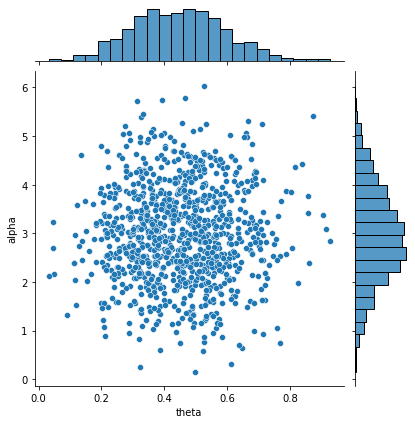

In [17]:
sns.jointplot(data=sim.draws_pd(), x='theta', y='alpha')
plt.show()

In [18]:
lambdas = sim.draws_pd()['lambda'].values
accidents = sim.draws_pd().accidents.values

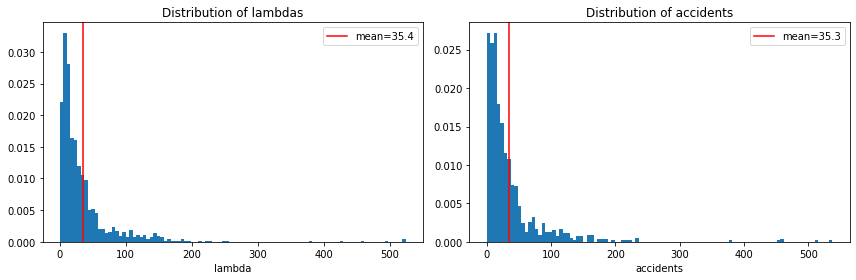

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].hist(lambdas, density=True, bins=100)
axes[0].axvline(x=lambdas.mean(), color='r', label=f'mean={lambdas.mean():.1f}')
axes[0].set_title('Distribution of lambdas')
axes[0].set_xlabel('lambda')
axes[0].legend()

axes[1].hist(accidents, density=True, bins=100)
axes[1].axvline(x=accidents.mean(), color='r', label=f'mean={accidents.mean():.1f}')
axes[1].set_title('Distribution of accidents')
axes[1].set_xlabel('accidents')
axes[1].legend()

plt.tight_layout()
plt.show()

The parameters have normal distributions and lambdas as well as accidents appear to be log-normally distributed.  

### Posterior predictive distribution with common $\alpha$

In [20]:
%%writefile airline_fit.stan

data {
  int<lower=1> N;
  vector[N] miles;
  int accidents[N];
}

parameters {
  real alpha;
  real theta;
}

transformed parameters {
  real lambda[N];
  for (i in 1:N) {
    lambda[i] = exp(alpha + theta * miles[i]);
  }
}


model {
  alpha ~ normal(3, 1);
  theta ~ normal(0.45, 0.15);
  
  for (i in 1:N) {
    accidents[i] ~ poisson(lambda[i]);
  }
}

Overwriting airline_fit.stan


In [21]:
fit_model = CmdStanModel(stan_file='airline_fit.stan')

INFO:cmdstanpy:compiling stan file /home/airline_fit.stan to exe file /home/airline_fit
INFO:cmdstanpy:compiled model executable: /home/airline_fit
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/airline_fit.hpp /home/airline_fit.stan
Warning in '/home/airline_fit.stan', line 5, column 2: Declaration of arrays
    by placing brackets after a variable name is deprecated and will be
    removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/home/airline_fit.stan', line 14, column 2: Declaration of arrays
    by placing brackets after a variable name is deprecated and will be
    removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2

In [22]:
data_fit = {'N': len(df), 'miles': df['Miles centered'].values, 'accidents': df['Fatal accidents'].values}
fit = fit_model.sample(data=data_fit, seed=15042023)

INFO:cmdstanpy:CmdStan start processing
chain 1 |                                                                                                                                                                    | 00:00 Status
chain 2 |                                                                                                                                                                    | 00:00 Status

chain 3 |                                                                                                                                                                    | 00:00 Status


chain 1 |███████▍                                                                                                                                                            | 00:00 Status
chain 2 |███████▍                                                                                                                                                            | 00:00 Status

chain 3 |███████


INFO:cmdstanpy:CmdStan done processing.


In [23]:
fit_df = fit.draws_pd()
fit_df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,theta,lambda[1],lambda[2],lambda[3],lambda[4],lambda[5],lambda[6],lambda[7],lambda[8],lambda[9],lambda[10]
0,511.952,0.992241,0.994404,1.0,3.0,0.0,-511.355,3.16988,-0.018742,24.6457,24.4447,24.1139,23.9096,23.7608,23.6635,23.7328,23.5794,23.0507,23.1920
1,511.880,0.845742,0.994404,2.0,3.0,0.0,-510.837,3.15012,-0.008717,23.7188,23.6286,23.4794,23.3866,23.3189,23.2744,23.3060,23.2359,22.9921,23.0575
2,511.539,0.952048,0.994404,2.0,3.0,0.0,-511.530,3.18673,-0.071500,27.6383,26.7881,25.4312,24.6190,24.0397,23.6662,23.9317,23.3469,21.4120,21.9169
3,511.577,0.969425,0.994404,2.0,3.0,0.0,-511.049,3.22241,-0.009186,25.5192,25.4170,25.2478,25.1428,25.0660,25.0156,25.0515,24.9720,24.6959,24.7700
4,511.097,0.889576,0.994404,1.0,1.0,0.0,-511.078,3.25045,-0.006677,26.1231,26.0470,25.9209,25.8424,25.7850,25.7473,25.7742,25.7147,25.5078,25.5634


In [24]:
years = df['Year'].values
observed_lambda = df['Fatal accidents'].values
sampled_lambdas = fit_df.loc[:, "lambda[1]":"lambda[10]"]

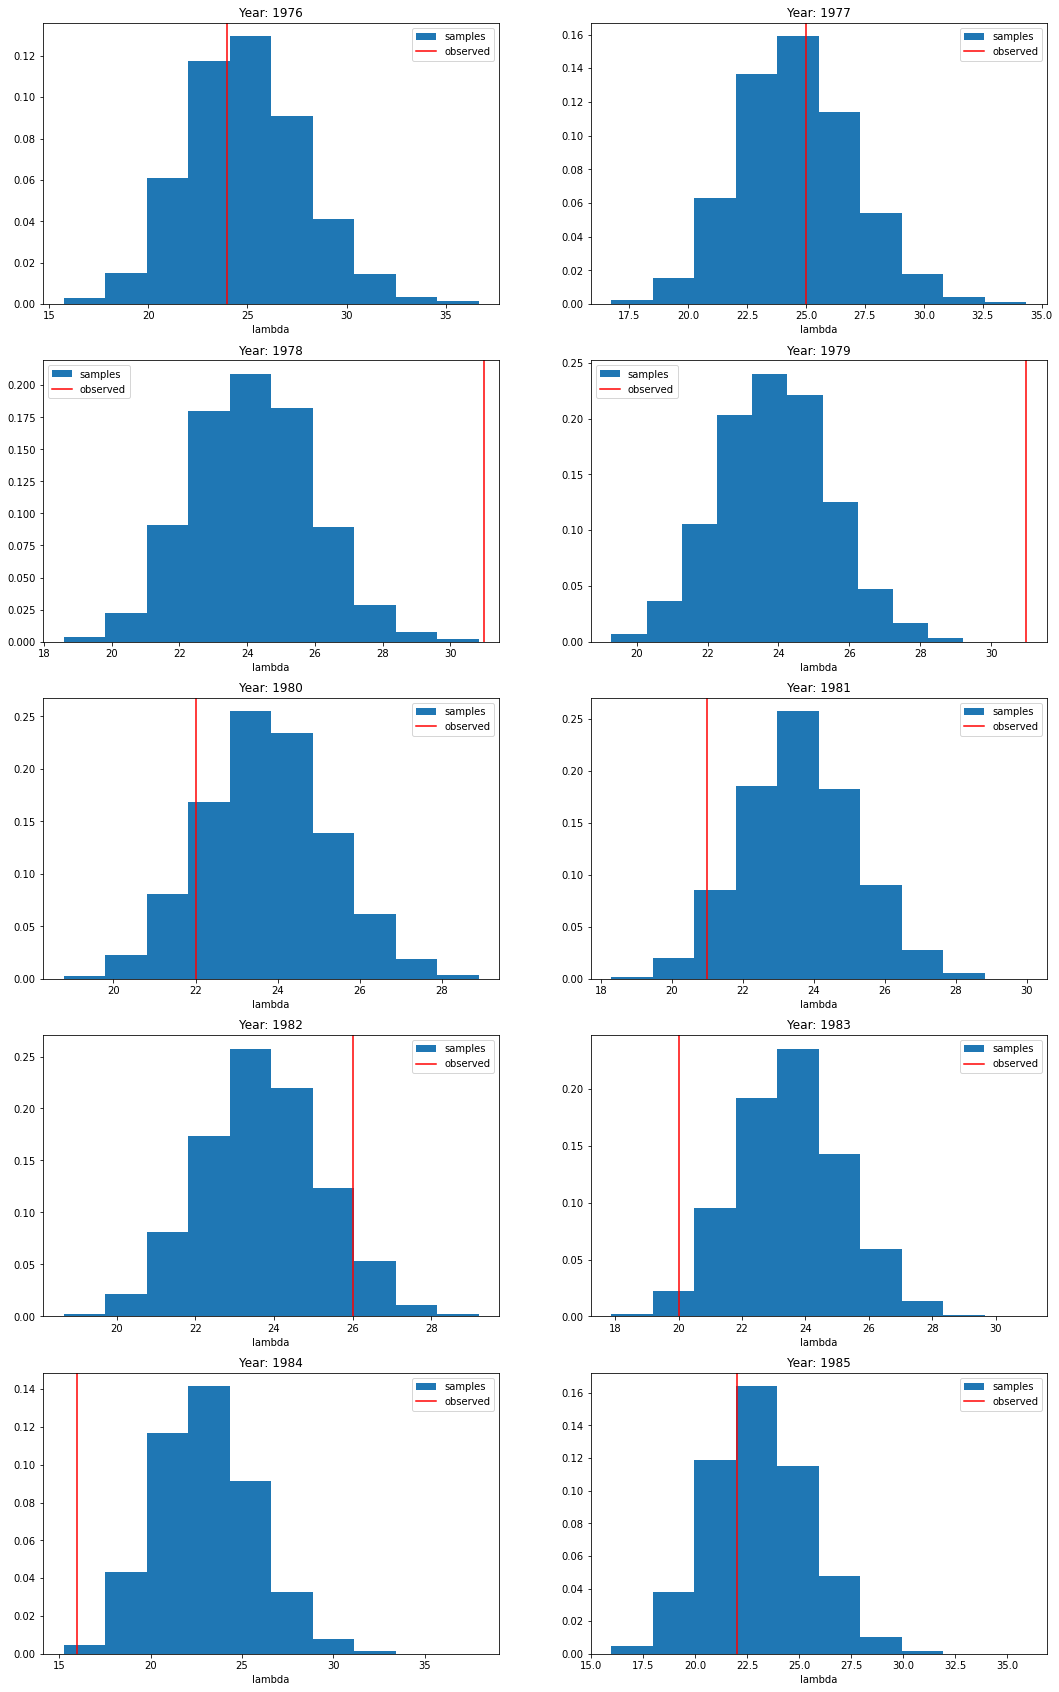

In [26]:
fig, axes = plt.subplots(int(len(df)/2), 2, figsize=(18, 30))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.hist(sampled_lambdas[f'lambda[{i + 1}]'].values, density=True, label='samples')
    ax.axvline(x=observed_lambda[i], color='r', label='observed')
    ax.set_xlabel('lambda')
    ax.set_title(f'Year: {years[i]}')
    ax.legend()

### Posterior predictive distribution with $\alpha_i$ for each year

In [35]:
%%writefile airline_fit_2.stan

data {
  int<lower=1> N;
  vector[N] miles;
  int accidents[N];
}

parameters {
  real alpha[N];
  real theta;
}

transformed parameters {
  real lambda[N];
  for (i in 1:N) {
    lambda[i] = exp(alpha[i] + theta * miles[i]);
  }
}


model {
  alpha ~ normal(3, 1);
  theta ~ normal(0.45, 0.15);
  
  for (i in 1:N) {
    accidents[i] ~ poisson(lambda[i]);
  }
}

Overwriting airline_fit_2.stan


In [36]:
fit_model_2 = CmdStanModel(stan_file='airline_fit_2.stan')

INFO:cmdstanpy:compiling stan file /home/airline_fit_2.stan to exe file /home/airline_fit_2
INFO:cmdstanpy:compiled model executable: /home/airline_fit_2
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/airline_fit_2.hpp /home/airline_fit_2.stan
Warning in '/home/airline_fit_2.stan', line 5, column 2: Declaration of
    arrays by placing brackets after a variable name is deprecated and will
    be removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/home/airline_fit_2.stan', line 9, column 2: Declaration of
    arrays by placing brackets after a variable name is deprecated and will
    be removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/home/airline_fit_2.stan', line 14, column 2: Declaration of
    arrays by placing brackets after a variable name is deprecated

In [37]:
fit_2 = fit_model_2.sample(data=data_fit, seed=15042023)

INFO:cmdstanpy:CmdStan start processing
chain 1 |                                                                                                                                                                    | 00:00 Status
chain 2 |                                                                                                                                                                    | 00:00 Status

chain 3 |                                                                                                                                                                    | 00:00 Status


chain 1 |███████▍                                                                                                                                                            | 00:00 Status

chain 3 |███████▍                                                                                                                                                            | 00:00 Status


chain 4 |█████


INFO:cmdstanpy:CmdStan done processing.


In [38]:
fit_2_df = fit_2.draws_pd()
fit_2_df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha[1],alpha[2],alpha[3],...,lambda[1],lambda[2],lambda[3],lambda[4],lambda[5],lambda[6],lambda[7],lambda[8],lambda[9],lambda[10]
0,514.442,0.979758,0.350659,3.0,15.0,0.0,-508.207,3.67734,3.32388,3.27108,...,27.6307,21.1154,23.0540,33.6475,20.4597,20.6079,32.3520,25.3537,16.3881,27.8950
1,513.362,0.763645,0.350659,3.0,15.0,0.0,-506.734,3.70803,3.38702,3.40186,...,30.3668,23.6140,26.9050,31.6340,26.7067,14.5331,28.5439,22.4823,10.6202,23.1259
2,515.600,1.000000,0.350659,3.0,7.0,0.0,-511.011,3.40683,3.36783,3.51529,...,24.2886,24.5853,31.0216,37.9246,20.2783,18.7581,21.4980,19.0095,17.5661,17.7065
3,512.872,0.801215,0.350659,2.0,7.0,0.0,-502.506,3.14189,3.43596,3.56334,...,20.1154,27.9012,33.4865,40.2215,17.7494,17.4370,19.7456,18.0483,13.0973,22.9558
4,515.027,0.976581,0.350659,4.0,15.0,0.0,-510.239,4.09736,3.68403,3.64489,...,27.1762,21.6828,28.4838,22.9908,25.3166,24.4923,31.3400,19.7729,22.1784,19.0815


In [39]:
years = df['Year'].values
observed_lambda = df['Fatal accidents'].values
sampled_lambdas = fit_2_df.loc[:, "lambda[1]":"lambda[10]"]

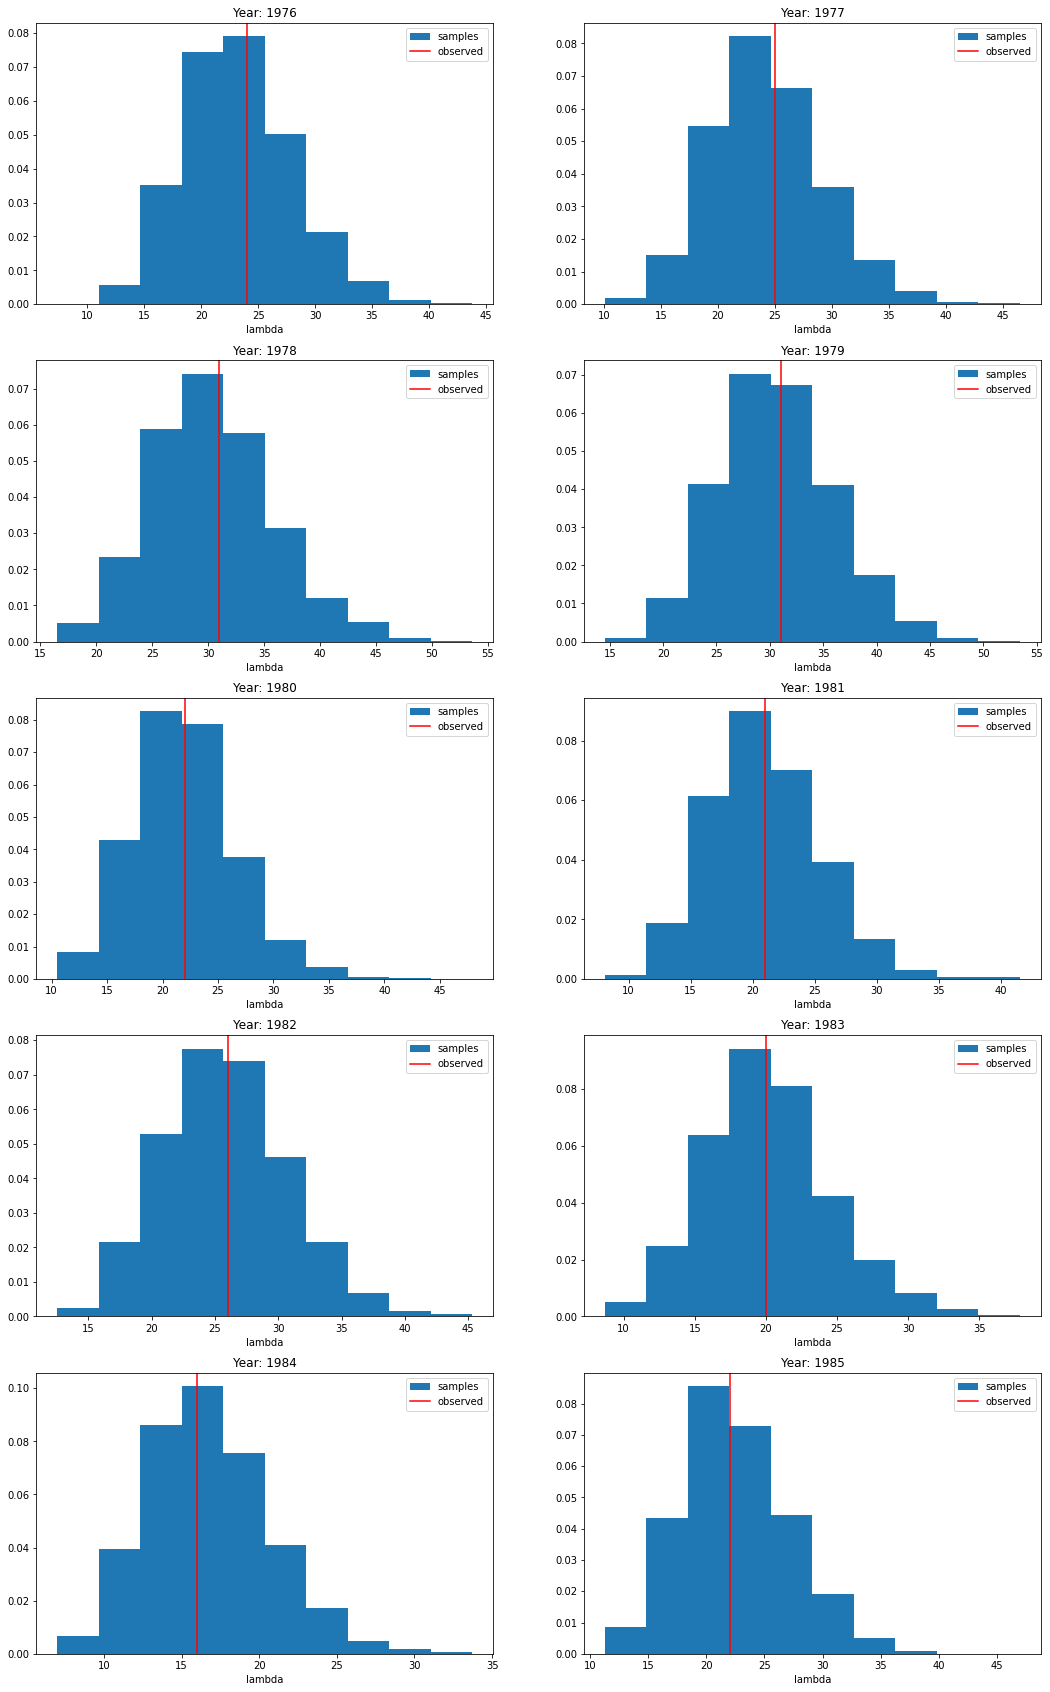

In [40]:
fig, axes = plt.subplots(int(len(df)/2), 2, figsize=(18, 30))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.hist(sampled_lambdas[f'lambda[{i + 1}]'].values, density=True, label='samples')
    ax.axvline(x=observed_lambda[i], color='r', label='observed')
    ax.set_xlabel('lambda')
    ax.set_title(f'Year: {years[i]}')
    ax.legend()

### Conclusions 
When using a single value for the parameter $\alpha$, the posterior distributions have difficulty in accurately reflecting the observed data. However, by introducing individual intercepts $\alpha_i$ for each year, the model significantly improves its ability to fit the data. In fact, it can be argued that the model now provides a rather accurate representation of the observed values.
It was essential to carefully select appropriate parameters for the prior distribution to ensure a meaningful analysis. Initially, the prior exhibited a broad range of plausible outcomes for the number of accidents. However, after conducting the posterior predictive analysis, the range of likely outcomes has been effectively narrowed down, resulting in a more precise understanding of the accident trends.